In [1]:
%load_ext tensorboard

In [2]:
from typing import Optional, Callable, Union
import numpy as np
import pandas as pd

from pathlib import Path
import glob

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# custom class for Early Stop and function for fixing random seed
from early_stop import EarlyStopper
from random_seed import seed_everything

In [3]:
seed_everything(42)

In [4]:
learning_rate = 0.01
batch_size = 256
epochs = 100

img_height = 40
img_width = 10

In [5]:
class SeqImg(Dataset):
    def __init__(self, folder_path='img/single_digit', transform=None):
        self.folder_path = folder_path
        self.files_list = glob.glob(self.folder_path + '/*.png', recursive=True)
        self.labels_list = [int(Path(x).name.split('_')[0]) for x in self.files_list]
        self.data_df = pd.DataFrame({'file_path': self.files_list, 'label': self.labels_list})
        
        self.transform = transform
        
    def __len__(self):
        return len(self.files_list)
    
    def __getitem__(self, index: int):
        image = np.asarray(Image.open(self.files_list[index]))
        label = torch.tensor(self.labels_list[index])
        file_path = self.files_list[index]
        if self.transform is not None:
            image = self.transform(image)            
        return image, label, file_path

In [6]:
trans_to_tensor = transforms.ToTensor()

In [7]:
img_dataset = SeqImg(transform=trans_to_tensor)

In [8]:
len(img_dataset)

2000

In [9]:
train_test_split_size = (len(img_dataset) - 300, 300)
train_val_ds, test_ds = random_split(img_dataset, train_test_split_size)

In [10]:
train_val_split_size = (len(train_val_ds) - 200, 200)
train_ds, val_ds = random_split(train_val_ds, train_val_split_size)

In [11]:
len(train_ds)

1500

In [12]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=200, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=300, shuffle=True)

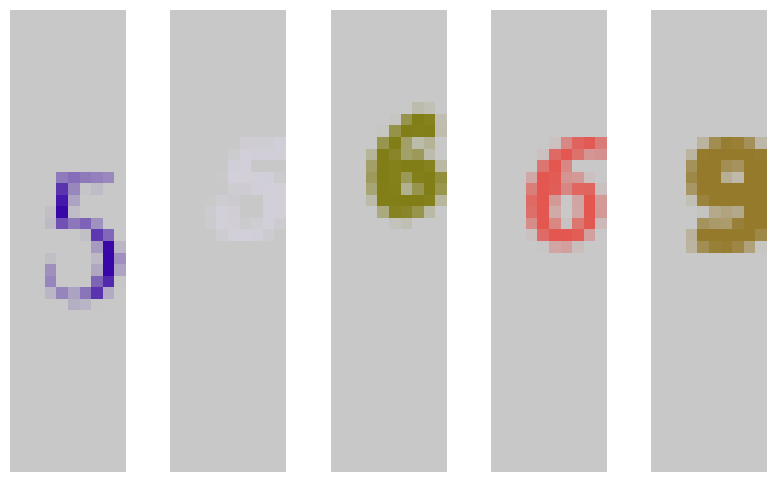

In [13]:
sample_img, sample_labels, sample_file_path = next(iter(train_loader))

plt.rcParams['figure.figsize'] = (10, 6)
fig, axs = plt.subplots(ncols=5)

for i, img_arr in enumerate(sample_img[0:5]):
    axs[i].imshow(transforms.ToPILImage()(img_arr))
    axs[i].axis('off')

# Model Building

In [14]:
class CNN(nn.Module):
    def __init__(self, img_height=img_height, img_width=img_width, conv1_channel=64, conv2_channel=32, fc_node=1024):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(*[
            nn.Conv2d(3, conv1_channel, 3, padding=1),
            nn.BatchNorm2d(conv1_channel),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(conv1_channel, conv2_channel, 3, padding=1), 
            nn.BatchNorm2d(conv2_channel),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        ])
        
        self.fc_block = nn.Sequential(*[
            nn.Flatten(),
            nn.Linear((img_height//4) * (img_width//4) * conv2_channel, fc_node),
            nn.BatchNorm1d(fc_node),
            nn.ReLU(),
            nn.Linear(fc_node, 10)
        ])
       
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, X, softmax=False):
        X = self.conv_blocks(X)
        X = self.fc_block(X)
        if softmax:
            X = self.softmax(X)
            
        return X

In [15]:
def train_classification_model(data_loader: DataLoader, lr: float, epochs: int,
                               model_trained: Optional[nn.Module] = None, model_class: Optional[Callable] = None, 
                               num_epochs_to_save: float = np.inf, model_path: str = 'Model/Pretrained_CNN', 
                               train_acc: bool = False, epochs_trained_before: int = 0,
                               early_stop: bool = False, es_after_epoch: int = 0, val_loader: Optional[DataLoader] = None, 
                               patience: int = 10, min_delta: float = 0, tensorboard_path: str = 'runs/CNN',                              
                               **kwargs) -> nn.Module:
    
    """
    data_loader: Data Loader of training data.
    
    lr, epochs: Hyperparameters. 
    
    model_trained, model_class: Either a trained model instance (model_trained), or a model class that is callable (model_class) to create a new model instance.
    
    num_epochs_to_save, model_path: For every `num_epochs_to_save` epochs, th emodel will be saved to folder `model_path`. `num_epochs_to_save=np.inf` means never save the model.
    
    train_acc: Calculate the training accuracy for every epoch (and send to Tensorboard) or not
    
    epochs_trained_before: if the model is trained before, this number is added to the number of epochs in this training process. Useful when passing a trained model to here for more training epochs.
    
    early_stop: Early Stop or not.
    
    es_after_epoch: Epochs smaller than `es_after_epoch` will not trigger the calculation of early stop.
    
    val_loader: Data Loader of validation data (for early stop).
    
    patience, min_delta: arguments for `EarlyStopper`
    
    tensorboard_path: Folder path where the `SummaryWriter` for Tensorboard to write the data to
    
    kwargs: arguments for the callable model class(if any)     
    """
    
    writer = SummaryWriter(tensorboard_path)
    
    Path(model_path).mkdir(parents=True, exist_ok=True)
    
    model_to_train = model_trained or model_class(**kwargs)
    opt = optim.Adam(model_to_train.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    if early_stop:
        early_stopper = EarlyStopper(patience, min_delta)
        
    for epoch in tqdm(range(epochs_trained_before, epochs_trained_before + epochs), position=0):
        model_to_train.train()
        tot_loss = 0
        num_data = 0
        for inputs, targets, *_ in data_loader:
            opt.zero_grad()
            y_pred = model_to_train(inputs)
            loss = loss_fn(y_pred, targets)
            tot_loss += loss * len(targets)
            num_data += len(targets)
            loss.backward()
            opt.step()
        writer.add_scalar('Loss/train', tot_loss / num_data, epoch)
        
        if not( (epoch + 1) % num_epochs_to_save):
            Path(model_path).mkdir(parents=True, exist_ok=True)
            torch.save(model_to_train, model_path + f'/model_ep{epoch + 1}.pt')
        
        if train_acc:
            model_to_train.eval()
            correct_train = 0
            for inputs, targets, *_ in data_loader:
                y_pred = model_to_train(inputs, softmax=True).argmax(dim=-1)
                correct_train += sum([a==b for a, b in zip(y_pred, targets)])
            writer.add_scalar('Accuracy/train', correct_train / num_data, epoch)
            
        if early_stop and (epoch + 1) > es_after_epoch:
            model_to_train.eval()
            tot_val_loss = 0
            num_val_data = 0
            for inputs, targets, *_ in val_loader:
                y_pred = model_to_train(inputs)
                loss = loss_fn(y_pred, targets)
                tot_val_loss += loss * len(targets)
                num_val_data += len(targets)
            writer.add_scalar('Loss/validation', tot_val_loss / num_val_data, epoch)
            stop_training = early_stopper(tot_val_loss / num_val_data)
            if stop_training:
                print(f"Training early stopped at Epoch {epoch + 1}.")
                torch.save(model_to_train, model_path + f'/model_ep{epoch + 1}.pt')
                writer.flush()
                writer.close()
                return model_to_train
            
    torch.save(model_to_train, model_path + f'/model_ep{epoch + 1}.pt')
    writer.flush()
    writer.close()
    return model_to_train

In [16]:
cnn_model = train_classification_model(train_loader, lr=learning_rate, epochs=1, model_class=CNN)

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


In [17]:
%tensorboard --logdir=runs

In [18]:
cnn_model = train_classification_model(model_trained=cnn_model, data_loader=train_loader, lr=learning_rate, epochs=200, 
                                       num_epochs_to_save=10, epochs_trained_before=1, 
                                       early_stop=True, es_after_epoch=100, val_loader=val_loader)

 57%|███████████████████████▌                 | 115/200 [02:58<02:11,  1.55s/it]

Training early stopped at Epoch 117.


# Model Evaluation

In [19]:
def eval_prediction(model=cnn_model, loader=val_loader):
    model.eval()
    pred_df_list = []
    for inputs, targets, file_path in loader:
        y_pred = model(inputs, softmax=True).argmax(dim=-1)
        pred_df_list += [pd.DataFrame({'img_path': file_path, 'actual_label': targets.numpy(), 'pred': y_pred.numpy()})]
        
    pred_df = pd.concat(pred_df_list, ignore_index=True)
    
    print(f"Accuracy Score: {accuracy_score(pred_df['actual_label'], pred_df['pred'])}")
    print(classification_report(pred_df['actual_label'], pred_df['pred']))    
    print(confusion_matrix(pred_df['actual_label'], pred_df['pred']))
    return pred_df

In [20]:
val_df = eval_prediction()

Accuracy Score: 0.96
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        22
           1       1.00      1.00      1.00        25
           2       0.90      0.95      0.93        20
           3       1.00      1.00      1.00        16
           4       1.00      0.94      0.97        16
           5       1.00      0.92      0.96        24
           6       0.96      0.96      0.96        25
           7       1.00      1.00      1.00        10
           8       0.92      0.96      0.94        24
           9       0.94      0.94      0.94        18

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200

[[21  0  0  0  0  0  1  0  0  0]
 [ 0 25  0  0  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  1  0]
 [ 0  0  0 16  0  0  0  0  0  0]
 [ 0  0  1  0 15  0  0  0  0  0]
 [ 1  0  0  0  0 22  0  0  0  1]
 [ 0  0  1  0  0  0 24

In [21]:
test_df = eval_prediction(loader=test_loader)

Accuracy Score: 0.9866666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        24
           2       0.97      1.00      0.99        37
           3       1.00      1.00      1.00        28
           4       1.00      0.97      0.98        32
           5       1.00      0.97      0.98        33
           6       0.97      0.97      0.97        33
           7       0.97      1.00      0.99        39
           8       0.96      1.00      0.98        24
           9       1.00      0.96      0.98        28

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

[[22  0  0  0  0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  0  0  0]
 [ 0  0 37  0  0  0  0  0  0  0]
 [ 0  0  0 28  0  0  0  0  0  0]
 [ 0  0  0  0 31  0  0  0  1  0]
 [ 0  0  0  0  0 32  0  1  0  0]
 [ 0  0 

In [22]:
torch.save(cnn_model, 'Model/Pretrained_CNN/final_cnn.pt')